reference: https://machinelearningmastery.com/implement-bagging-scratch-python/

# Understanding Bootstrap Aggregation

In [25]:
from random import seed
from random import random
from random import randrange
import matplotlib.pyplot as plt

Create a random sub-sample from the dataset with replacement

In [2]:
def subsample(dataset, ratio=1.0):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

Calculate the mean of a list of numbers

In [3]:
def mean(numbers):
    return sum(numbers) / float(len(numbers))

Calculate the true mean and compare against bootstrap sample means. 

Each bootstrap sample is created as a 10% sample of the original 20 observation dataset (or 2 observations). We then experiment by creating 1, 10, 100 bootstrap samples of the original dataset, calculate their mean value, then average all of those estimated mean values.

In [32]:
seed(1)
# True mean
dataset = [[randrange(10)] for i in range(20)]
print('True Mean: %.3f' % mean([row[0] for row in dataset]))

True Mean: 4.500


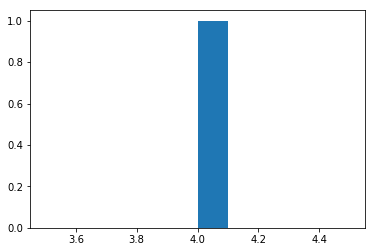

Samples=1, Estimated Mean: 4.000


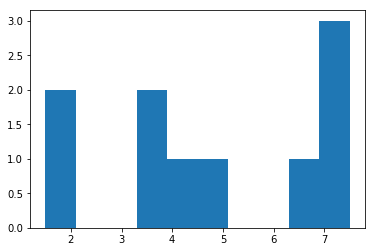

Samples=10, Estimated Mean: 4.700


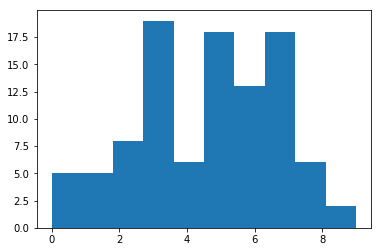

Samples=100, Estimated Mean: 4.570


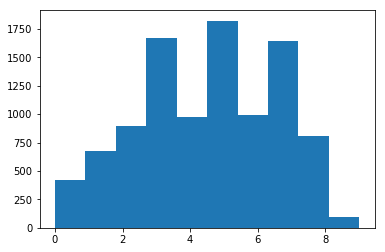

Samples=10000, Estimated Mean: 4.511


In [33]:
# Estimated means
ratio = 0.10
for size in [1, 10, 100, 10000]:
    sample_means = list()
    for i in range(size):
        sample = subsample(dataset, ratio)
        sample_mean = mean([row[0] for row in sample])
        sample_means.append(sample_mean)
    plt.hist(sample_means)
    plt.show()
    print('Samples=%d, Estimated Mean: %.3f' % (size, mean(sample_means)))

## Bagging Algorithm on the Sonar dataset

In [6]:
import pandas as pd
from random import seed
from random import randrange
from csv import reader

In [7]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
data = pd.read_csv(url, header=None)
data.to_csv('sonar.all-data.csv')

In [8]:
# Load a CSV file
def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            if not row:
                continue
            dataset.append(row)
    return dataset

In [9]:
# Convert string column to integer
def str_column_to_int(dataset, column):
    class_values = [row[column] for row in dataset]
    unique = set(class_values)
    lookup = dict()
    for i, value in enumerate(unique):
        lookup[value] = i
    for row in dataset:
        row[column] = lookup[row[column]] # replace 
    return lookup

we define helper functions:

- test_split() to split a dataset into groups, 
- gini_index() to evaluate a split point, 
- get_split() to find an optimal split point, to_terminal(), 
- split() and build_tree() used to create a single decision tree, 
- predict() to make a prediction with a decision tree and the 
- subsample() function described in the previous step to make a subsample of the training dataset

In [10]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

In [11]:
# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [12]:
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

In [13]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

In [14]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

In [15]:
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset)) # 0, 1
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
        # for i in range(len(dataset)):
        # row = dataset[randrange(len(dataset))]
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

In [16]:
# Create a terminal node value
def to_terminal(group):
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

In [17]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

In [18]:
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

In [19]:
# Create a random subsample from the dataset with replacement
def subsample(dataset, ratio):
    sample = list()
    n_sample = round(len(dataset) * ratio)
    while len(sample) < n_sample:
        index = randrange(len(dataset))
        sample.append(dataset[index])
    return sample

In [20]:
# Make a prediction with a list of bagged trees
def bagging_predict(trees, row):
    predictions = [predict(tree, row) for tree in trees]
    return max(set(predictions), key=predictions.count)
 
# Bootstrap Aggregation Algorithm
def bagging(train, test, max_depth, min_size, sample_size, n_trees):
    trees = list()
    for i in range(n_trees):
        sample = subsample(train, sample_size)
        tree = build_tree(sample, max_depth, min_size)
        trees.append(tree)
    predictions = [bagging_predict(trees, row) for row in test]
    return(predictions)

In [42]:
# Test bagging on the sonar dataset
seed(1)
# load and prepare data
filename = 'sonar.all-data.csv'
dataset = load_csv(filename)
dataset.pop(0)
str_column_to_int(dataset, len(dataset[0])-1)

{'M': 0, 'R': 1}

In [43]:
n_folds = 5
max_depth = 6
min_size = 2
sample_size = 0.50
for n_trees in [1, 5, 10, 50]:
    scores = evaluate_algorithm(dataset, bagging, n_folds, max_depth, min_size, sample_size, n_trees)
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Trees: 1
Scores: [90.2439024390244, 90.2439024390244, 80.48780487804879, 82.92682926829268, 92.6829268292683]
Mean Accuracy: 87.317%
Trees: 5
Scores: [90.2439024390244, 80.48780487804879, 82.92682926829268, 95.1219512195122, 85.36585365853658]
Mean Accuracy: 86.829%
Trees: 10
Scores: [92.6829268292683, 87.8048780487805, 92.6829268292683, 90.2439024390244, 90.2439024390244]
Mean Accuracy: 90.732%
Trees: 50
Scores: [90.2439024390244, 82.92682926829268, 85.36585365853658, 92.6829268292683, 95.1219512195122]
Mean Accuracy: 89.268%


# Sci-kit learn Implementation

In [44]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import numpy as np

In [45]:
seed(1)
# evaluate algorithm
n_folds = 5
max_depth = 6
min_size = 2
sample_size = 0.50

x = np.zeros((len(dataset),len(dataset[0])-1))
y = np.zeros(len(dataset))
for i in range(0, len(dataset)):
    x[i,:] = dataset[i][0:len(dataset[0])-1]
    y[i] = dataset[i][len(dataset[0])-1]


for n_trees in [1, 5, 10, 50]:
    clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators = n_trees, max_samples=sample_size)
    scores = cross_val_score(clf, x, y, cv=n_folds, scoring='accuracy')
    print('Trees: %d' % n_trees)
    print('Scores: %s' % scores)
    print('Mean Accuracy: {:3f}%'.format(np.mean(scores)*100))

Trees: 1
Scores: [ 0.69767442  1.          1.          1.          0.7804878 ]
Mean Accuracy: 89.563244%
Trees: 5
Scores: [ 0.74418605  1.          1.          1.          0.75609756]
Mean Accuracy: 90.005672%
Trees: 10
Scores: [ 0.72093023  1.          1.          1.          0.7804878 ]
Mean Accuracy: 90.028361%
Trees: 50
Scores: [ 0.72093023  1.          1.          1.          0.7804878 ]
Mean Accuracy: 90.028361%
